In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import calculate_metrics, train_model, count_parameters
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# use data augmentation
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor()
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
# load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)
# create data loaders
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [6]:
# load ResNet50 model using timm
model = timm.create_model('resnet50', pretrained=True)
# change the last layer to 10 classes
model.fc = nn.Linear(2048, 10)
# freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
# move model to GPU
model = model.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print("Number of trainable parameters: {}".format(count_parameters(model)))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


Number of trainable parameters: 20490


In [7]:
# use train_model function to train the model
train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)

Epoch: 1/10 	 Train loss: 2.206 	 Train accuracy: 0.229 	 val loss: 2.196 	 val accuracy: 0.328
Epoch: 2/10 	 Train loss: 2.068 	 Train accuracy: 0.324 	 val loss: 2.070 	 val accuracy: 0.357
Epoch: 3/10 	 Train loss: 1.989 	 Train accuracy: 0.353 	 val loss: 1.949 	 val accuracy: 0.374
Epoch: 4/10 	 Train loss: 1.936 	 Train accuracy: 0.364 	 val loss: 1.971 	 val accuracy: 0.389
Epoch: 5/10 	 Train loss: 1.898 	 Train accuracy: 0.372 	 val loss: 1.937 	 val accuracy: 0.388
Epoch: 6/10 	 Train loss: 1.871 	 Train accuracy: 0.376 	 val loss: 2.015 	 val accuracy: 0.400
Epoch: 7/10 	 Train loss: 1.850 	 Train accuracy: 0.386 	 val loss: 1.908 	 val accuracy: 0.398
Epoch: 8/10 	 Train loss: 1.827 	 Train accuracy: 0.388 	 val loss: 1.903 	 val accuracy: 0.409
Epoch: 9/10 	 Train loss: 1.818 	 Train accuracy: 0.387 	 val loss: 1.923 	 val accuracy: 0.415
Epoch: 10/10 	 Train loss: 1.800 	 Train accuracy: 0.392 	 val loss: 2.097 	 val accuracy: 0.411


------------------Classification Report------------------
		 precision 	 recall 	 f1-score 	 support
airplane:		 0.430 		 0.477 		 0.452 		 1000.0
automobile:		 0.537 		 0.539 		 0.538 		 1000.0
bird:		 0.430 		 0.336 		 0.377 		 1000.0
--------------------------------------------------------
Accuracy: 					 0.443 		 10000
Error rate: 					 0.557 		 10000
Macro avg: 	 0.443 		 0.445 		 0.444 		 10000
Weighted avg: 	 0.443 		 0.443 		 2.000 		 10000
--------------------------------------------------------



------------------Confusion Matrix------------------


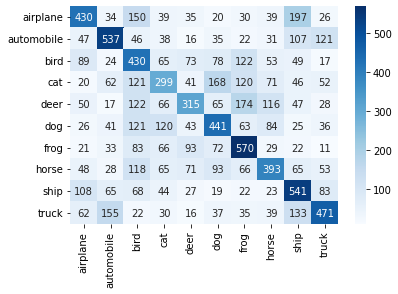

In [8]:
 # test the model on test data
calculate_metrics(model, test_loader, classes=test_dataset.classes, device=device)

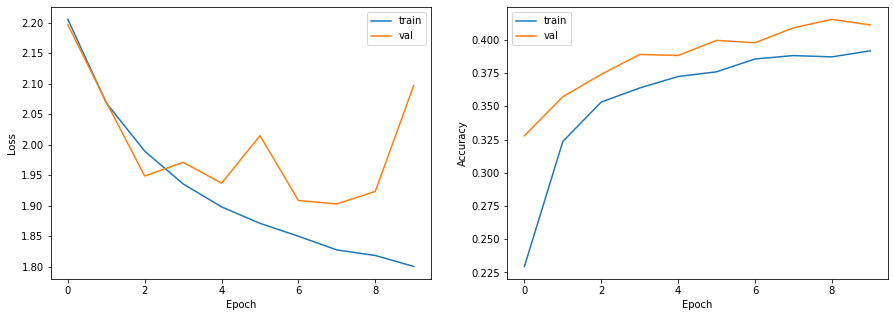

In [9]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# load ResNet18 model
student_model = timm.create_model('resnet18', pretrained=True)
# change the last layer to 10 classes
student_model.fc = nn.Linear(512, 10)
# move model to GPU
student_model = student_model.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [11]:
# define a function to find the best alpha and T
def find_best_alpha_T(student_model, teacher_model, train_loader, test_loader, criterion, optimizer, epochs=10, T_list=[1, 10, 100], alpha_list=[0.1, 0.5, 0.9]):
    best_acc = 0
    best_alpha = 0
    best_T = 0
    for T in T_list:
        for alpha in alpha_list:
            print(f'alpha={alpha}, T={T}')
            student_model = timm.create_model('resnet18', pretrained=True)
            student_model.fc = nn.Linear(512, 10)
            student_model = student_model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(student_model.fc.parameters(), lr=1e-4)
            train_loss, test_loss, train_acc, test_acc = train_model(student_model, train_loader, test_loader, epochs=epochs, criterion=criterion, optimizer=optimizer, device=device, teacher_model=model, T=T, alpha=alpha)
            if test_acc[-1] > best_acc:
                best_acc = test_acc[-1]
                best_alpha = alpha
                best_T = T
    return best_acc, best_alpha, best_T


In [12]:
# find the best alpha and T
best_acc, best_alpha, best_T = find_best_alpha_T(student_model, model, train_loader, val_loader, criterion, optimizer, epochs=4, T_list=[1, 10, 100], alpha_list=[0.1, 0.5, 0.9])

alpha=0.1, T=1
Epoch: 1/4 	 Train loss: 2.323 	 Train accuracy: 0.208 	 val loss: 2.018 	 val accuracy: 0.285
Epoch: 2/4 	 Train loss: 2.213 	 Train accuracy: 0.312 	 val loss: 1.949 	 val accuracy: 0.335
Epoch: 3/4 	 Train loss: 2.190 	 Train accuracy: 0.344 	 val loss: 1.907 	 val accuracy: 0.359
Epoch: 4/4 	 Train loss: 2.178 	 Train accuracy: 0.357 	 val loss: 1.905 	 val accuracy: 0.369
alpha=0.5, T=1
Epoch: 1/4 	 Train loss: 2.243 	 Train accuracy: 0.228 	 val loss: 1.957 	 val accuracy: 0.313
Epoch: 2/4 	 Train loss: 2.092 	 Train accuracy: 0.334 	 val loss: 1.861 	 val accuracy: 0.361
Epoch: 3/4 	 Train loss: 2.058 	 Train accuracy: 0.366 	 val loss: 1.822 	 val accuracy: 0.374
Epoch: 4/4 	 Train loss: 2.038 	 Train accuracy: 0.379 	 val loss: 1.797 	 val accuracy: 0.389
alpha=0.9, T=1
Epoch: 1/4 	 Train loss: 2.173 	 Train accuracy: 0.228 	 val loss: 1.982 	 val accuracy: 0.294
Epoch: 2/4 	 Train loss: 1.948 	 Train accuracy: 0.327 	 val loss: 1.852 	 val accuracy: 0.351
Epoch

In [17]:
# train the student model with the best alpha and T
student_model = timm.create_model('resnet18', pretrained=True)
student_model.fc = nn.Linear(512, 10)
student_model = student_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)
train_loss, test_loss, train_acc, test_acc = train_model(student_model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device, teacher_model=model, T=10, alpha=best_alpha)

Epoch: 1/10 	 Train loss: 23.676 	 Train accuracy: 0.615 	 val loss: 0.786 	 val accuracy: 0.721
Epoch: 2/10 	 Train loss: 23.267 	 Train accuracy: 0.749 	 val loss: 0.686 	 val accuracy: 0.762
Epoch: 3/10 	 Train loss: 23.166 	 Train accuracy: 0.787 	 val loss: 0.624 	 val accuracy: 0.780
Epoch: 4/10 	 Train loss: 23.099 	 Train accuracy: 0.813 	 val loss: 0.590 	 val accuracy: 0.800
Epoch: 5/10 	 Train loss: 23.054 	 Train accuracy: 0.833 	 val loss: 0.581 	 val accuracy: 0.804
Epoch: 6/10 	 Train loss: 23.018 	 Train accuracy: 0.848 	 val loss: 0.577 	 val accuracy: 0.804
Epoch: 7/10 	 Train loss: 22.989 	 Train accuracy: 0.861 	 val loss: 0.551 	 val accuracy: 0.810
Epoch: 8/10 	 Train loss: 22.962 	 Train accuracy: 0.872 	 val loss: 0.535 	 val accuracy: 0.819
Epoch: 9/10 	 Train loss: 22.932 	 Train accuracy: 0.886 	 val loss: 0.527 	 val accuracy: 0.819
Epoch: 10/10 	 Train loss: 22.916 	 Train accuracy: 0.892 	 val loss: 0.538 	 val accuracy: 0.826


------------------Classification Report------------------
		 precision 	 recall 	 f1-score 	 support
airplane:		 0.892 		 0.838 		 0.864 		 1000.0
automobile:		 0.914 		 0.893 		 0.903 		 1000.0
bird:		 0.784 		 0.831 		 0.807 		 1000.0
--------------------------------------------------------
Accuracy: 					 0.840 		 10000
Error rate: 					 0.160 		 10000
Macro avg: 	 0.840 		 0.839 		 0.840 		 10000
Weighted avg: 	 0.840 		 0.840 		 2.000 		 10000
--------------------------------------------------------



------------------Confusion Matrix------------------
Number of trainable parameters: 11181642


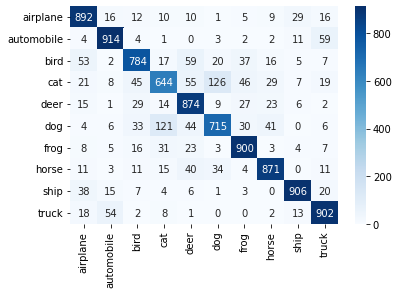

In [18]:
# test the student model on test data
calculate_metrics(student_model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

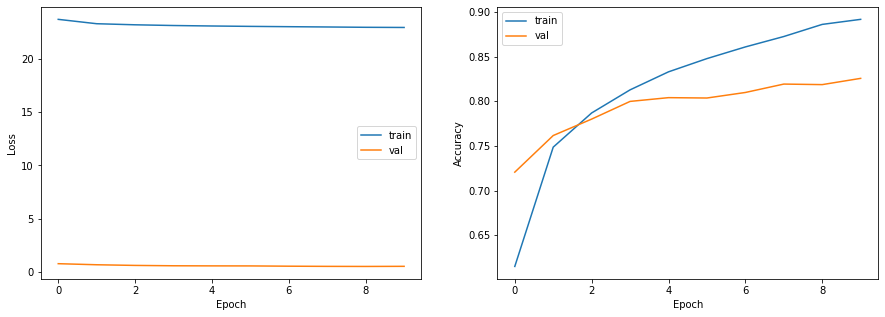

In [19]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# fine-tune all of resnet18 model
model = timm.create_model('resnet18', pretrained=True)
model.fc = nn.Linear(512, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)

Epoch: 1/10 	 Train loss: 1.138 	 Train accuracy: 0.605 	 val loss: 0.817 	 val accuracy: 0.713
Epoch: 2/10 	 Train loss: 0.753 	 Train accuracy: 0.741 	 val loss: 0.706 	 val accuracy: 0.755
Epoch: 3/10 	 Train loss: 0.635 	 Train accuracy: 0.779 	 val loss: 0.647 	 val accuracy: 0.780
Epoch: 4/10 	 Train loss: 0.553 	 Train accuracy: 0.808 	 val loss: 0.610 	 val accuracy: 0.786
Epoch: 5/10 	 Train loss: 0.494 	 Train accuracy: 0.827 	 val loss: 0.619 	 val accuracy: 0.787
Epoch: 6/10 	 Train loss: 0.448 	 Train accuracy: 0.843 	 val loss: 0.587 	 val accuracy: 0.800
Epoch: 7/10 	 Train loss: 0.405 	 Train accuracy: 0.860 	 val loss: 0.594 	 val accuracy: 0.808
Epoch: 8/10 	 Train loss: 0.369 	 Train accuracy: 0.871 	 val loss: 0.573 	 val accuracy: 0.804
Epoch: 9/10 	 Train loss: 0.334 	 Train accuracy: 0.882 	 val loss: 0.584 	 val accuracy: 0.806
Epoch: 10/10 	 Train loss: 0.310 	 Train accuracy: 0.891 	 val loss: 0.606 	 val accuracy: 0.806


------------------Classification Report------------------
		 precision 	 recall 	 f1-score 	 support
airplane:		 0.838 		 0.887 		 0.862 		 1000.0
automobile:		 0.903 		 0.906 		 0.904 		 1000.0
bird:		 0.761 		 0.841 		 0.799 		 1000.0
--------------------------------------------------------
Accuracy: 					 0.836 		 10000
Error rate: 					 0.164 		 10000
Macro avg: 	 0.836 		 0.837 		 0.836 		 10000
Weighted avg: 	 0.836 		 0.836 		 2.000 		 10000
--------------------------------------------------------



------------------Confusion Matrix------------------
Number of trainable parameters: 11181642


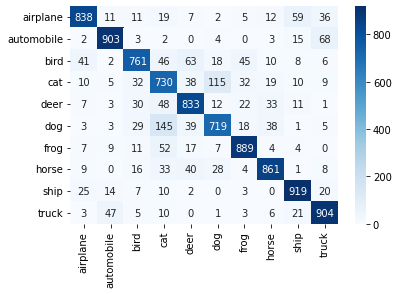

In [21]:
# test the student model on test data
calculate_metrics(model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

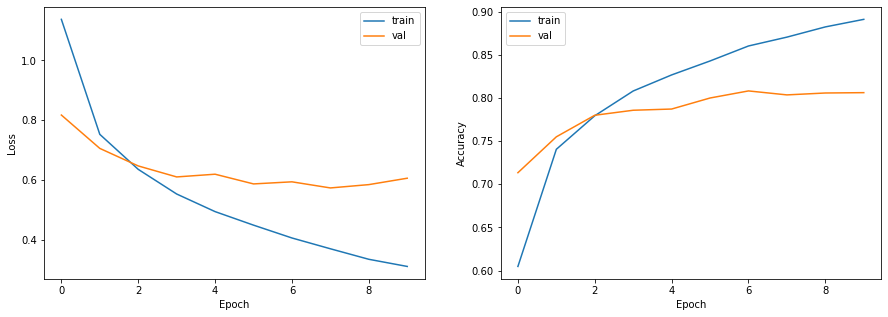

In [22]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
# fine-tune all of resnet50 model
model = timm.create_model('resnet50', pretrained=True)
model.fc = nn.Linear(2048, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)


Epoch: 1/10 	 Train loss: 2.002 	 Train accuracy: 0.304 	 val loss: 1.642 	 val accuracy: 0.471
Epoch: 2/10 	 Train loss: 1.389 	 Train accuracy: 0.520 	 val loss: 1.321 	 val accuracy: 0.575
Epoch: 3/10 	 Train loss: 1.116 	 Train accuracy: 0.609 	 val loss: 1.082 	 val accuracy: 0.637
Epoch: 4/10 	 Train loss: 0.952 	 Train accuracy: 0.665 	 val loss: 0.929 	 val accuracy: 0.684
Epoch: 5/10 	 Train loss: 0.866 	 Train accuracy: 0.698 	 val loss: 0.979 	 val accuracy: 0.694
Epoch: 6/10 	 Train loss: 0.784 	 Train accuracy: 0.725 	 val loss: 0.757 	 val accuracy: 0.739
Epoch: 7/10 	 Train loss: 0.722 	 Train accuracy: 0.750 	 val loss: 0.709 	 val accuracy: 0.756
Epoch: 8/10 	 Train loss: 0.665 	 Train accuracy: 0.768 	 val loss: 0.682 	 val accuracy: 0.765
Epoch: 9/10 	 Train loss: 0.621 	 Train accuracy: 0.784 	 val loss: 0.793 	 val accuracy: 0.769
Epoch: 10/10 	 Train loss: 0.590 	 Train accuracy: 0.795 	 val loss: 0.627 	 val accuracy: 0.786


------------------Classification Report------------------
		 precision 	 recall 	 f1-score 	 support
airplane:		 0.765 		 0.799 		 0.781 		 1000.0
automobile:		 0.858 		 0.921 		 0.888 		 1000.0
bird:		 0.755 		 0.747 		 0.751 		 1000.0
--------------------------------------------------------
Accuracy: 					 0.798 		 10000
Error rate: 					 0.202 		 10000
Macro avg: 	 0.798 		 0.800 		 0.799 		 10000
Weighted avg: 	 0.798 		 0.798 		 2.000 		 10000
--------------------------------------------------------



------------------Confusion Matrix------------------
Number of trainable parameters: 11181642


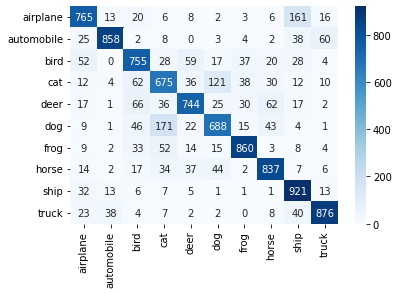

In [24]:
# test the student model on test data
calculate_metrics(model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

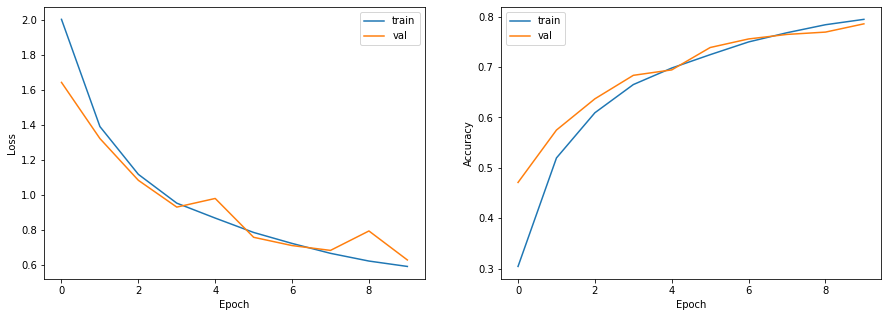

In [25]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()